<a href="https://colab.research.google.com/github/khataei/PE-classification-DeepLearning/blob/master/Tunned-Talos-1-CNN-activity-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Talos Tuner for CNN Activity Classifier

In this notebook, we use SKlearn  to tune a CNN neural net to classify PE activity.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4946466680677553101
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10798057925511371666
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5227768459458449771
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9111570899242302647
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


'2.3.1'

#### Set hyperparameters

In [2]:
# output directory name:
# output_dir = 'model_output/tunecnn1'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [3]:
# sklearn hyperparams
params = {
    'n_conv_1':[512, 768], # filters, a.k.a. kernels
    'k_conv_1':[3, 7], # kernel length
    'n_conv_2':[512, 768], # filters, a.k.a. kernels
    'k_conv_2':[3, 7], # kernel length
    'n_conv_3':[512, 768], # filters, a.k.a. kernels
    'k_conv_3':[3, 7], # kernel length
    'maxpooling_pool_size':[2, 4],
    'avepooling_pool_size':[2, 4],
    'n_dense_1':[512, 768],
    'dropout_1':[0.22, 0.3],
    'n_dense_2':[512],
    'dropout_2':[0.25],
    'activation':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 20
cv = 3
epochs = 60
batch_size = 128


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [6]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [7]:
y = to_categorical(labels_array_int, num_classes=n_class)


### Splitting and shuffeling the data

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [9]:
params

{'n_conv_1': [512, 768],
 'k_conv_1': [3, 7],
 'n_conv_2': [512, 768],
 'k_conv_2': [3, 7],
 'n_conv_3': [512, 768],
 'k_conv_3': [3, 7],
 'maxpooling_pool_size': [2, 4],
 'avepooling_pool_size': [2, 4],
 'n_dense_1': [512, 768],
 'dropout_1': [0.22, 0.3],
 'n_dense_2': [512],
 'dropout_2': [0.25],
 'activation': ['elu',
  'relu',
  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x16b3bc11888>]}

In [10]:
def create_model(n_conv_1=256, k_conv_1=3, n_conv_2=256, k_conv_2=3, n_conv_3=256, k_conv_3=3,
                 maxpooling_pool_size = 2, avepooling_pool_size = 2, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation= 'elu'
                ):
    model = Sequential()
    model.add(Conv1D(n_conv_1, k_conv_1, activation=activation, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation=activation))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation=activation))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(n_dense_1, activation=activation))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
#     model.summary()
    print(f"""n_conv_1 = {n_conv_1}, k_conv_1 = {k_conv_1},  n_conv_2 = {n_conv_2}, k_conv_2 = {k_conv_2}, 
          n_conv_3 = {n_conv_3},  k_conv_3 = {k_conv_3},  maxpooling_pool_size = {maxpooling_pool_size},
          avepooling_pool_size = {avepooling_pool_size},  n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation=  {activation}""")
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

    return model

In [11]:
model_default = create_model()
model_default.summary()

n_conv_1 = 256, k_conv_1 = 3,  n_conv_2 = 256, k_conv_2 = 3, 
          n_conv_3 = 256,  k_conv_3 = 3,  maxpooling_pool_size = 2,
          avepooling_pool_size = 2,  n_dense_1 = 256, dropout_1 = 0.2,
          n_dense_2 = 256, dropout_2 = 0.2, activation=  elu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 256)           196

In [12]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [13]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

n_conv_1 = 512, k_conv_1 = 7,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 768,  k_conv_3 = 7,  maxpooling_pool_size = 2,
          avepooling_pool_size = 2,  n_dense_1 = 768, dropout_1 = 0.3,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  elu
Epoch 1/60
304/304 [==============================] - 14s 46ms/step - loss: 1.3752 - accuracy: 0.4230
Epoch 2/60
304/304 [==============================] - 13s 44ms/step - loss: 1.9304 - accuracy: 0.4914
Epoch 3/60
304/304 [==============================] - 13s 43ms/step - loss: 1.0700 - accuracy: 0.5395
Epoch 4/60
304/304 [==============================] - 13s 44ms/step - loss: 0.9075 - accuracy: 0.6143
Epoch 5/60
304/304 [==============================] - 13s 44ms/step - loss: 0.7626 - accuracy: 0.6847
Epoch 6/60
304/304 [==============================] - 13s 44ms/step - loss: 0.6613 - accuracy: 0.7359
Epoch 7/60
304/304 [==============================] - 14s 45ms/step - loss: 0.5799 - accuracy: 0.7689
Epoch 8/60
304/304 [===

304/304 [==============================] - 13s 43ms/step - loss: 0.5084 - accuracy: 0.8006
Epoch 10/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4835 - accuracy: 0.8125
Epoch 11/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4701 - accuracy: 0.8178
Epoch 12/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4605 - accuracy: 0.8206
Epoch 13/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4505 - accuracy: 0.8237
Epoch 14/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4309 - accuracy: 0.8308
Epoch 15/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4158 - accuracy: 0.8384
Epoch 16/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4125 - accuracy: 0.8396
Epoch 17/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3924 - accuracy: 0.8489
Epoch 18/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3876 -

304/304 [==============================] - 13s 44ms/step - loss: 0.3043 - accuracy: 0.8766
Epoch 26/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2950 - accuracy: 0.8794
Epoch 27/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2967 - accuracy: 0.8793
Epoch 28/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2912 - accuracy: 0.8818
Epoch 29/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2925 - accuracy: 0.8802
Epoch 30/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2830 - accuracy: 0.8850
Epoch 31/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2734 - accuracy: 0.8877
Epoch 32/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2707 - accuracy: 0.8874
Epoch 33/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2806 - accuracy: 0.8859
Epoch 34/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2632 -

304/304 [==============================] - 18s 60ms/step - loss: 0.2087 - accuracy: 0.9203
Epoch 39/60
304/304 [==============================] - 18s 60ms/step - loss: 0.2175 - accuracy: 0.9199
Epoch 40/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1927 - accuracy: 0.9266
Epoch 41/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1853 - accuracy: 0.9295
Epoch 42/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1934 - accuracy: 0.9284
Epoch 43/60
304/304 [==============================] - 18s 60ms/step - loss: 0.2032 - accuracy: 0.9258
Epoch 44/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1879 - accuracy: 0.9288
Epoch 45/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1816 - accuracy: 0.9319
Epoch 46/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1784 - accuracy: 0.9333
Epoch 47/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1979 -

304/304 [==============================] - 18s 60ms/step - loss: 0.1902 - accuracy: 0.9311
Epoch 52/60
304/304 [==============================] - 18s 60ms/step - loss: 0.2002 - accuracy: 0.9277
Epoch 53/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1811 - accuracy: 0.9328
Epoch 54/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1842 - accuracy: 0.9325
Epoch 55/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1721 - accuracy: 0.9352
Epoch 56/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1695 - accuracy: 0.9380
Epoch 57/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1809 - accuracy: 0.9346
Epoch 58/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1674 - accuracy: 0.9396
Epoch 59/60
304/304 [==============================] - 18s 60ms/step - loss: 0.1835 - accuracy: 0.9337
Epoch 60/60
152/152 [==============================] - 2s 14ms/step - loss: 0.5964 - 

304/304 [==============================] - 12s 39ms/step - loss: 1.0649 - accuracy: 0.5605
Epoch 2/60
304/304 [==============================] - 12s 38ms/step - loss: 0.6671 - accuracy: 0.7377
Epoch 3/60
304/304 [==============================] - 12s 38ms/step - loss: 0.4737 - accuracy: 0.8192
Epoch 4/60
304/304 [==============================] - 12s 38ms/step - loss: 0.3866 - accuracy: 0.8532
Epoch 5/60
304/304 [==============================] - 12s 38ms/step - loss: 0.3480 - accuracy: 0.8694
Epoch 6/60
304/304 [==============================] - 12s 38ms/step - loss: 0.3201 - accuracy: 0.8779
Epoch 7/60
304/304 [==============================] - 12s 38ms/step - loss: 0.3072 - accuracy: 0.8860
Epoch 8/60
304/304 [==============================] - 12s 38ms/step - loss: 0.2726 - accuracy: 0.8972
Epoch 9/60
304/304 [==============================] - 12s 38ms/step - loss: 0.2628 - accuracy: 0.8982
Epoch 10/60
304/304 [==============================] - 12s 38ms/step - loss: 0.2702 - accurac

304/304 [==============================] - 12s 38ms/step - loss: 0.2221 - accuracy: 0.9139
Epoch 13/60
304/304 [==============================] - 12s 38ms/step - loss: 0.2129 - accuracy: 0.9172
Epoch 14/60
304/304 [==============================] - 12s 38ms/step - loss: 0.2001 - accuracy: 0.9221
Epoch 15/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1935 - accuracy: 0.9251
Epoch 16/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1852 - accuracy: 0.9260
Epoch 17/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1870 - accuracy: 0.9273
Epoch 18/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1726 - accuracy: 0.9341
Epoch 19/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1657 - accuracy: 0.9351
Epoch 20/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1612 - accuracy: 0.9379
Epoch 21/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1494 -

304/304 [==============================] - 12s 38ms/step - loss: 0.1379 - accuracy: 0.9469
Epoch 26/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1314 - accuracy: 0.9496
Epoch 27/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1285 - accuracy: 0.9512
Epoch 28/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1259 - accuracy: 0.9526
Epoch 29/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1246 - accuracy: 0.9534
Epoch 30/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1206 - accuracy: 0.9538
Epoch 31/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1193 - accuracy: 0.9539
Epoch 32/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1225 - accuracy: 0.9541
Epoch 33/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1185 - accuracy: 0.9557
Epoch 34/60
304/304 [==============================] - 12s 38ms/step - loss: 0.1114 -

C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 7 from 4 for '{{node conv1d_32/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_32/conv1d/ExpandDims, conv1d_32/conv1d/ExpandDims_1)' with input shapes: [?,1,4,768], [1,7,768,768].

During handling of the above exception, another exception occurred:

Traceback (most recent ca

n_conv_1 = 768, k_conv_1 = 7,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 7,  maxpooling_pool_size = 2,
          avepooling_pool_size = 4,  n_dense_1 = 512, dropout_1 = 0.22,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  elu
Epoch 1/60
304/304 [==============================] - 12s 41ms/step - loss: 1.3582 - accuracy: 0.4248
Epoch 2/60
304/304 [==============================] - 12s 41ms/step - loss: 0.9802 - accuracy: 0.6037
Epoch 3/60
304/304 [==============================] - 12s 40ms/step - loss: 0.7848 - accuracy: 0.6912
Epoch 4/60
304/304 [==============================] - 12s 41ms/step - loss: 0.9657 - accuracy: 0.6589
Epoch 5/60
304/304 [==============================] - 12s 41ms/step - loss: 0.7080 - accuracy: 0.7186
Epoch 6/60
304/304 [==============================] - 12s 41ms/step - loss: 0.5845 - accuracy: 0.7696
Epoch 7/60
304/304 [==============================] - 12s 41ms/step - loss: 0.5355 - accuracy: 0.7892
Epoch 8/60
304/304 [==

304/304 [==============================] - 12s 41ms/step - loss: 0.4434 - accuracy: 0.8234
Epoch 10/60
304/304 [==============================] - 12s 41ms/step - loss: 0.4262 - accuracy: 0.8313
Epoch 11/60
304/304 [==============================] - 12s 41ms/step - loss: 0.4078 - accuracy: 0.8393
Epoch 12/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3949 - accuracy: 0.8439
Epoch 13/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3745 - accuracy: 0.8523
Epoch 14/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3530 - accuracy: 0.8605
Epoch 15/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3540 - accuracy: 0.8597
Epoch 16/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3395 - accuracy: 0.8662
Epoch 17/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3281 - accuracy: 0.8705
Epoch 18/60
304/304 [==============================] - 12s 41ms/step - loss: 0.3245 -

304/304 [==============================] - 12s 41ms/step - loss: 0.2780 - accuracy: 0.8875
Epoch 26/60
304/304 [==============================] - 12s 41ms/step - loss: 0.2774 - accuracy: 0.8886
Epoch 27/60
304/304 [==============================] - 12s 41ms/step - loss: 0.2720 - accuracy: 0.8904
Epoch 28/60
304/304 [==============================] - 12s 40ms/step - loss: 0.2639 - accuracy: 0.8941
Epoch 29/60
304/304 [==============================] - 12s 41ms/step - loss: 0.2542 - accuracy: 0.8985
Epoch 30/60
304/304 [==============================] - 13s 42ms/step - loss: 0.2604 - accuracy: 0.8960
Epoch 31/60
304/304 [==============================] - 13s 44ms/step - loss: 0.2604 - accuracy: 0.8949
Epoch 32/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2475 - accuracy: 0.9010
Epoch 33/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2469 - accuracy: 0.9017
Epoch 34/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2488 -

C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 7 from 5 for '{{node conv1d_50/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_50/conv1d/ExpandDims, conv1d_50/conv1d/ExpandDims_1)' with input shapes: [?,1,5,768], [1,7,768,512].

During handling of the above exception, another exception occurred:

Traceback (most recent ca

n_conv_1 = 512, k_conv_1 = 3,  n_conv_2 = 512, k_conv_2 = 7, 
          n_conv_3 = 768,  k_conv_3 = 7,  maxpooling_pool_size = 2,
          avepooling_pool_size = 2,  n_dense_1 = 768, dropout_1 = 0.22,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  relu
Epoch 1/60
304/304 [==============================] - 16s 53ms/step - loss: 1.0130 - accuracy: 0.5734
Epoch 2/60
304/304 [==============================] - 16s 52ms/step - loss: 0.5568 - accuracy: 0.7763
Epoch 3/60
304/304 [==============================] - 16s 52ms/step - loss: 0.4145 - accuracy: 0.8405
Epoch 4/60
304/304 [==============================] - 16s 52ms/step - loss: 0.3532 - accuracy: 0.8640
Epoch 5/60
304/304 [==============================] - 16s 52ms/step - loss: 0.3124 - accuracy: 0.8817
Epoch 6/60
304/304 [==============================] - 16s 52ms/step - loss: 0.2885 - accuracy: 0.8923
Epoch 7/60
304/304 [==============================] - 16s 52ms/step - loss: 0.2685 - accuracy: 0.8998
Epoch 8/60
304/304 [=

304/304 [==============================] - 16s 52ms/step - loss: 0.2477 - accuracy: 0.9071
Epoch 10/60
304/304 [==============================] - 16s 52ms/step - loss: 0.2244 - accuracy: 0.9126
Epoch 11/60
304/304 [==============================] - 16s 52ms/step - loss: 0.2163 - accuracy: 0.9157
Epoch 12/60
304/304 [==============================] - 16s 52ms/step - loss: 0.2006 - accuracy: 0.9222
Epoch 13/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1933 - accuracy: 0.9236
Epoch 14/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1884 - accuracy: 0.9256
Epoch 15/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1728 - accuracy: 0.9317
Epoch 16/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1670 - accuracy: 0.9344
Epoch 17/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1631 - accuracy: 0.9370
Epoch 18/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1652 -

304/304 [==============================] - 16s 52ms/step - loss: 0.1404 - accuracy: 0.9461
Epoch 23/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1336 - accuracy: 0.9481
Epoch 24/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1355 - accuracy: 0.9470
Epoch 25/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1319 - accuracy: 0.9512
Epoch 26/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1270 - accuracy: 0.9519
Epoch 27/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1243 - accuracy: 0.9521
Epoch 28/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1204 - accuracy: 0.9536
Epoch 29/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1183 - accuracy: 0.9547
Epoch 30/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1188 - accuracy: 0.9548
Epoch 31/60
304/304 [==============================] - 16s 52ms/step - loss: 0.1137 -

304/304 [==============================] - 16s 53ms/step - loss: 0.2565 - accuracy: 0.8972
Epoch 36/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2464 - accuracy: 0.9021
Epoch 37/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2543 - accuracy: 0.9016
Epoch 38/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2425 - accuracy: 0.9030
Epoch 39/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2385 - accuracy: 0.9054
Epoch 40/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2748 - accuracy: 0.8914
Epoch 41/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2379 - accuracy: 0.9057
Epoch 42/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2265 - accuracy: 0.9121
Epoch 43/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2214 - accuracy: 0.9123
Epoch 44/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2201 -

304/304 [==============================] - 16s 53ms/step - loss: 0.2175 - accuracy: 0.9164
Epoch 49/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2124 - accuracy: 0.9166
Epoch 50/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2042 - accuracy: 0.9218
Epoch 51/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2112 - accuracy: 0.9183
Epoch 52/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2073 - accuracy: 0.9212
Epoch 53/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2131 - accuracy: 0.9199
Epoch 54/60
304/304 [==============================] - 16s 53ms/step - loss: 0.1979 - accuracy: 0.9227
Epoch 55/60
304/304 [==============================] - 16s 53ms/step - loss: 0.1892 - accuracy: 0.9268
Epoch 56/60
304/304 [==============================] - 16s 53ms/step - loss: 0.1955 - accuracy: 0.9249
Epoch 57/60
304/304 [==============================] - 16s 53ms/step - loss: 0.2077 -

152/152 [==============================] - 2s 15ms/step - loss: 0.3401 - accuracy: 0.8802


C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 7 from 4 for '{{node conv1d_77/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_77/conv1d/ExpandDims, conv1d_77/conv1d/ExpandDims_1)' with input shapes: [?,1,4,512], [1,7,512,512].

During handling of the above exception, another exception occurred:

Traceback (most recent ca

n_conv_1 = 768, k_conv_1 = 7,  n_conv_2 = 512, k_conv_2 = 7, 
          n_conv_3 = 768,  k_conv_3 = 3,  maxpooling_pool_size = 4,
          avepooling_pool_size = 4,  n_dense_1 = 512, dropout_1 = 0.22,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  elu
Epoch 1/60
304/304 [==============================] - 11s 38ms/step - loss: 1.3059 - accuracy: 0.4569
Epoch 2/60
304/304 [==============================] - 11s 37ms/step - loss: 1.0254 - accuracy: 0.5831
Epoch 3/60
304/304 [==============================] - 11s 37ms/step - loss: 0.8125 - accuracy: 0.6781
Epoch 4/60
304/304 [==============================] - 11s 37ms/step - loss: 1.2479 - accuracy: 0.5832
Epoch 5/60
304/304 [==============================] - 11s 37ms/step - loss: 0.7376 - accuracy: 0.7061
Epoch 6/60
304/304 [==============================] - 11s 37ms/step - loss: 0.6196 - accuracy: 0.7498
Epoch 7/60
304/304 [==============================] - 11s 37ms/step - loss: 0.5563 - accuracy: 0.7779
Epoch 8/60
304/304 [==

304/304 [==============================] - 11s 37ms/step - loss: 0.5176 - accuracy: 0.7980
Epoch 10/60
304/304 [==============================] - 11s 37ms/step - loss: 0.4542 - accuracy: 0.8205
Epoch 11/60
304/304 [==============================] - 11s 37ms/step - loss: 0.4477 - accuracy: 0.8265
Epoch 12/60
304/304 [==============================] - 11s 37ms/step - loss: 0.4163 - accuracy: 0.8376
Epoch 13/60
304/304 [==============================] - 11s 37ms/step - loss: 0.3962 - accuracy: 0.8469
Epoch 14/60
304/304 [==============================] - 11s 37ms/step - loss: 0.3900 - accuracy: 0.8469
Epoch 15/60
304/304 [==============================] - 11s 37ms/step - loss: 0.3764 - accuracy: 0.8537
Epoch 16/60
304/304 [==============================] - 11s 37ms/step - loss: 0.3516 - accuracy: 0.8627
Epoch 17/60
304/304 [==============================] - 11s 37ms/step - loss: 0.3493 - accuracy: 0.8670
Epoch 18/60
304/304 [==============================] - 11s 37ms/step - loss: 0.3480 -

304/304 [==============================] - 11s 37ms/step - loss: 0.2878 - accuracy: 0.8899
Epoch 23/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2908 - accuracy: 0.8897
Epoch 24/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2664 - accuracy: 0.8985
Epoch 25/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2619 - accuracy: 0.8990
Epoch 26/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2576 - accuracy: 0.9016
Epoch 27/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2637 - accuracy: 0.9020
Epoch 28/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2506 - accuracy: 0.9070
Epoch 29/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2428 - accuracy: 0.9085
Epoch 30/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2442 - accuracy: 0.9085
Epoch 31/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2387 -

304/304 [==============================] - 11s 37ms/step - loss: 0.2615 - accuracy: 0.8997
Epoch 38/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2550 - accuracy: 0.9020
Epoch 39/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2697 - accuracy: 0.8974
Epoch 40/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2531 - accuracy: 0.9029
Epoch 41/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2610 - accuracy: 0.9031
Epoch 42/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2554 - accuracy: 0.9041
Epoch 43/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2483 - accuracy: 0.9056
Epoch 44/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2551 - accuracy: 0.9048
Epoch 45/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2664 - accuracy: 0.9002
Epoch 46/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2430 -

304/304 [==============================] - 11s 37ms/step - loss: 0.2450 - accuracy: 0.9055
Epoch 50/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2506 - accuracy: 0.9035
Epoch 51/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2419 - accuracy: 0.9081
Epoch 52/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2429 - accuracy: 0.9080
Epoch 53/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2671 - accuracy: 0.9020
Epoch 54/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2403 - accuracy: 0.9079
Epoch 55/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2408 - accuracy: 0.9083
Epoch 56/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2357 - accuracy: 0.9116
Epoch 57/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2670 - accuracy: 0.9014
Epoch 58/60
304/304 [==============================] - 11s 37ms/step - loss: 0.2552 -

304/304 [==============================] - 13s 44ms/step - loss: 1.3232 - accuracy: 0.4530
Epoch 2/60
304/304 [==============================] - 13s 43ms/step - loss: 1.5983 - accuracy: 0.5208
Epoch 3/60
304/304 [==============================] - 13s 43ms/step - loss: 0.8769 - accuracy: 0.6466
Epoch 4/60
304/304 [==============================] - 13s 43ms/step - loss: 0.7540 - accuracy: 0.7031
Epoch 5/60
304/304 [==============================] - 13s 43ms/step - loss: 0.6509 - accuracy: 0.7460
Epoch 6/60
304/304 [==============================] - 13s 43ms/step - loss: 0.5906 - accuracy: 0.7708
Epoch 7/60
304/304 [==============================] - 13s 43ms/step - loss: 0.5435 - accuracy: 0.7898
Epoch 8/60
304/304 [==============================] - 13s 43ms/step - loss: 0.5052 - accuracy: 0.8017
Epoch 9/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4720 - accuracy: 0.8161
Epoch 10/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4618 - accurac

304/304 [==============================] - 13s 43ms/step - loss: 0.4514 - accuracy: 0.82530s - loss: 0.454
Epoch 13/60
304/304 [==============================] - 13s 43ms/step - loss: 0.4067 - accuracy: 0.8399
Epoch 14/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3863 - accuracy: 0.8482
Epoch 15/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3796 - accuracy: 0.8533
Epoch 16/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3683 - accuracy: 0.8553
Epoch 17/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3597 - accuracy: 0.8585
Epoch 18/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3441 - accuracy: 0.8660
Epoch 19/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3418 - accuracy: 0.8664
Epoch 20/60
304/304 [==============================] - 13s 43ms/step - loss: 0.3402 - accuracy: 0.8645
Epoch 21/60
304/304 [==============================] - 13s 43ms/step 

304/304 [==============================] - 13s 43ms/step - loss: 0.2874 - accuracy: 0.8874
Epoch 26/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2753 - accuracy: 0.8925
Epoch 27/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2951 - accuracy: 0.8872
Epoch 28/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2636 - accuracy: 0.8977
Epoch 29/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2569 - accuracy: 0.9018
Epoch 30/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2474 - accuracy: 0.9038
Epoch 31/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2515 - accuracy: 0.9034
Epoch 32/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2518 - accuracy: 0.9048
Epoch 33/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2371 - accuracy: 0.9093
Epoch 34/60
304/304 [==============================] - 13s 43ms/step - loss: 0.2335 -

304/304 [==============================] - 9s 31ms/step - loss: 0.2465 - accuracy: 0.9011
Epoch 39/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2402 - accuracy: 0.9034
Epoch 40/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2414 - accuracy: 0.9038
Epoch 41/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2398 - accuracy: 0.9053
Epoch 42/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2313 - accuracy: 0.9057
Epoch 43/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2323 - accuracy: 0.9078
Epoch 44/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2256 - accuracy: 0.9089
Epoch 45/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2361 - accuracy: 0.9072
Epoch 46/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2182 - accuracy: 0.9111
Epoch 47/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2183 - accuracy:

304/304 [==============================] - 9s 31ms/step - loss: 0.1979 - accuracy: 0.9215
Epoch 55/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2059 - accuracy: 0.9185
Epoch 56/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2068 - accuracy: 0.9173
Epoch 57/60
304/304 [==============================] - 9s 31ms/step - loss: 0.2006 - accuracy: 0.9218
Epoch 58/60
304/304 [==============================] - 9s 31ms/step - loss: 0.1970 - accuracy: 0.9229
Epoch 59/60
304/304 [==============================] - 9s 31ms/step - loss: 0.1992 - accuracy: 0.9206
Epoch 60/60
152/152 [==============================] - 2s 11ms/step - loss: 0.2827 - accuracy: 0.9197
n_conv_1 = 512, k_conv_1 = 7,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 3,  maxpooling_pool_size = 2,
          avepooling_pool_size = 2,  n_dense_1 = 512, dropout_1 = 0.3,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  elu
Epoch 1/60
304/304 [===============

304/304 [==============================] - 14s 45ms/step - loss: 0.5587 - accuracy: 0.7757
Epoch 5/60
304/304 [==============================] - 14s 45ms/step - loss: 0.5026 - accuracy: 0.7919
Epoch 6/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4960 - accuracy: 0.7988
Epoch 7/60
304/304 [==============================] - 14s 45ms/step - loss: 9.8635 - accuracy: 0.5670
Epoch 8/60
304/304 [==============================] - 14s 45ms/step - loss: 0.6840 - accuracy: 0.7321
Epoch 9/60
304/304 [==============================] - 14s 45ms/step - loss: 0.5770 - accuracy: 0.7752
Epoch 10/60
304/304 [==============================] - 14s 45ms/step - loss: 0.5348 - accuracy: 0.7937
Epoch 11/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4990 - accuracy: 0.8093
Epoch 12/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4774 - accuracy: 0.8174
Epoch 13/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4527 - accu

Epoch 17/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4716 - accuracy: 0.8173
Epoch 18/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4506 - accuracy: 0.8266
Epoch 19/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4217 - accuracy: 0.8370
Epoch 20/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4204 - accuracy: 0.8389
Epoch 21/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4020 - accuracy: 0.8462
Epoch 22/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4055 - accuracy: 0.8440
Epoch 23/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3897 - accuracy: 0.8492
Epoch 24/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3757 - accuracy: 0.8528
Epoch 25/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3715 - accuracy: 0.8543
Epoch 26/60
304/304 [==============================] - 14s 45ms/step - lo

304/304 [==============================] - 14s 45ms/step - loss: 0.3539 - accuracy: 0.8622
Epoch 30/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3378 - accuracy: 0.8657
Epoch 31/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3338 - accuracy: 0.8694
Epoch 32/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3399 - accuracy: 0.8676
Epoch 33/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3298 - accuracy: 0.8697
Epoch 34/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3144 - accuracy: 0.8743
Epoch 35/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3241 - accuracy: 0.8708
Epoch 36/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3075 - accuracy: 0.8758
Epoch 37/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3152 - accuracy: 0.8764
Epoch 38/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3072 -

304/304 [==============================] - 9s 29ms/step - loss: 0.1034 - accuracy: 0.9613
Epoch 44/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0991 - accuracy: 0.9622
Epoch 45/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0973 - accuracy: 0.9626
Epoch 46/60
304/304 [==============================] - 9s 29ms/step - loss: 0.1018 - accuracy: 0.9608
Epoch 47/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0963 - accuracy: 0.9628
Epoch 48/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0919 - accuracy: 0.9647
Epoch 49/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0930 - accuracy: 0.9643
Epoch 50/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0905 - accuracy: 0.9638
Epoch 51/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0943 - accuracy: 0.9639
Epoch 52/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0879 - accuracy:

304/304 [==============================] - 9s 29ms/step - loss: 0.0981 - accuracy: 0.9625
Epoch 58/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0861 - accuracy: 0.9676
Epoch 59/60
304/304 [==============================] - 9s 29ms/step - loss: 0.0961 - accuracy: 0.9627
Epoch 60/60
152/152 [==============================] - 1s 9ms/step - loss: 0.3745 - accuracy: 0.9295
n_conv_1 = 512, k_conv_1 = 7,  n_conv_2 = 512, k_conv_2 = 7, 
          n_conv_3 = 768,  k_conv_3 = 3,  maxpooling_pool_size = 4,
          avepooling_pool_size = 2,  n_dense_1 = 768, dropout_1 = 0.3,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  relu
Epoch 1/60
304/304 [==============================] - 9s 29ms/step - loss: 1.0606 - accuracy: 0.5574
Epoch 2/60
304/304 [==============================] - 9s 29ms/step - loss: 0.6903 - accuracy: 0.7272
Epoch 3/60
304/304 [==============================] - 9s 29ms/step - loss: 0.4747 - accuracy: 0.8192
Epoch 4/60
304/304 [==================

C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 7 from 5 for '{{node conv1d_140/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_140/conv1d/ExpandDims, conv1d_140/conv1d/ExpandDims_1)' with input shapes: [?,1,5,768], [1,7,768,512].

During handling of the above exception, another exception occurred:

Traceback (most recent

n_conv_1 = 512, k_conv_1 = 3,  n_conv_2 = 768, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 7,  maxpooling_pool_size = 2,
          avepooling_pool_size = 4,  n_dense_1 = 512, dropout_1 = 0.22,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x0000016B4BA21988>
Epoch 1/60
304/304 [==============================] - 14s 45ms/step - loss: 1.1401 - accuracy: 0.5192
Epoch 2/60
304/304 [==============================] - 14s 45ms/step - loss: 0.9038 - accuracy: 0.6425
Epoch 3/60
304/304 [==============================] - 14s 45ms/step - loss: 0.6302 - accuracy: 0.7445
Epoch 4/60
304/304 [==============================] - 14s 45ms/step - loss: 0.5547 - accuracy: 0.7727
Epoch 5/60
304/304 [==============================] - 14s 45ms/step - loss: 0.5206 - accuracy: 0.7865
Epoch 6/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4856 - accuracy: 0.8007
Epoch 7/60
304/304 [===============

304/304 [==============================] - 14s 45ms/step - loss: 0.4639 - accuracy: 0.8111
Epoch 8/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4420 - accuracy: 0.8206
Epoch 9/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4040 - accuracy: 0.8335
Epoch 10/60
304/304 [==============================] - 14s 45ms/step - loss: 1.1160 - accuracy: 0.7345
Epoch 11/60
304/304 [==============================] - 14s 45ms/step - loss: 0.4336 - accuracy: 0.8270
Epoch 12/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3985 - accuracy: 0.8400
Epoch 13/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3775 - accuracy: 0.8479
Epoch 14/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3642 - accuracy: 0.85320s - loss: 0.3632 - ac
Epoch 15/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3483 - accuracy: 0.8616
Epoch 16/60
304/304 [==============================] - 14s 45ms/s

304/304 [==============================] - 14s 45ms/step - loss: 0.3778 - accuracy: 0.8510
Epoch 20/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3687 - accuracy: 0.8552
Epoch 21/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3708 - accuracy: 0.8542
Epoch 22/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3550 - accuracy: 0.8614
Epoch 23/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3466 - accuracy: 0.8638
Epoch 24/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3485 - accuracy: 0.8634
Epoch 25/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3363 - accuracy: 0.8665
Epoch 26/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3318 - accuracy: 0.8685
Epoch 27/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3301 - accuracy: 0.8682
Epoch 28/60
304/304 [==============================] - 14s 45ms/step - loss: 0.3246 -

304/304 [==============================] - 13s 42ms/step - loss: 0.1073 - accuracy: 0.9592
Epoch 33/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0976 - accuracy: 0.9619
Epoch 34/60
304/304 [==============================] - 13s 42ms/step - loss: 0.1066 - accuracy: 0.9602
Epoch 35/60
304/304 [==============================] - 13s 42ms/step - loss: 0.1011 - accuracy: 0.9618
Epoch 36/60
304/304 [==============================] - 13s 41ms/step - loss: 0.1011 - accuracy: 0.9620
Epoch 37/60
304/304 [==============================] - 13s 42ms/step - loss: 0.1039 - accuracy: 0.9605
Epoch 38/60
304/304 [==============================] - 13s 42ms/step - loss: 0.1051 - accuracy: 0.9628
Epoch 39/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0927 - accuracy: 0.9648
Epoch 40/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0965 - accuracy: 0.9631
Epoch 41/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0949 -

304/304 [==============================] - 13s 42ms/step - loss: 0.0937 - accuracy: 0.9657
Epoch 46/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0912 - accuracy: 0.9658
Epoch 47/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0907 - accuracy: 0.9671
Epoch 48/60
304/304 [==============================] - 13s 42ms/step - loss: 0.1021 - accuracy: 0.9639
Epoch 49/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0987 - accuracy: 0.9651
Epoch 50/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0870 - accuracy: 0.9678
Epoch 51/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0806 - accuracy: 0.9702
Epoch 52/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0864 - accuracy: 0.9683
Epoch 53/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0911 - accuracy: 0.9664
Epoch 54/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0857 -

304/304 [==============================] - 13s 41ms/step - loss: 0.0823 - accuracy: 0.9700
Epoch 59/60
304/304 [==============================] - 13s 42ms/step - loss: 0.0809 - accuracy: 0.9704
Epoch 60/60
152/152 [==============================] - 2s 10ms/step - loss: 0.4331 - accuracy: 0.9375
n_conv_1 = 768, k_conv_1 = 7,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 3,  maxpooling_pool_size = 2,
          avepooling_pool_size = 2,  n_dense_1 = 512, dropout_1 = 0.3,
          n_dense_2 = 512, dropout_2 = 0.25, activation=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x0000016C72B8E088>
Epoch 1/60
304/304 [==============================] - 12s 40ms/step - loss: 1.1015 - accuracy: 0.5435
Epoch 2/60
304/304 [==============================] - 12s 40ms/step - loss: 0.7967 - accuracy: 0.6782
Epoch 3/60
304/304 [==============================] - 12s 40ms/step - loss: 0.7055 - accuracy: 0.7236
Epoch 4/60
304/304 [==========================

304/304 [==============================] - 12s 40ms/step - loss: 0.5545 - accuracy: 0.7774
Epoch 5/60
304/304 [==============================] - 12s 40ms/step - loss: 1.5558 - accuracy: 0.6870
Epoch 6/60
304/304 [==============================] - 12s 40ms/step - loss: 0.6178 - accuracy: 0.7541
Epoch 7/60
304/304 [==============================] - 12s 40ms/step - loss: 0.5393 - accuracy: 0.7846
Epoch 8/60
304/304 [==============================] - 12s 40ms/step - loss: 0.4917 - accuracy: 0.8024
Epoch 9/60
304/304 [==============================] - 12s 40ms/step - loss: 0.4601 - accuracy: 0.8147
Epoch 10/60
304/304 [==============================] - 12s 40ms/step - loss: 0.4430 - accuracy: 0.8242
Epoch 11/60
304/304 [==============================] - 12s 40ms/step - loss: 0.4254 - accuracy: 0.8319
Epoch 12/60
304/304 [==============================] - 12s 40ms/step - loss: 0.4162 - accuracy: 0.8365
Epoch 13/60
304/304 [==============================] - 12s 40ms/step - loss: 0.4055 - accu

Epoch 17/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3372 - accuracy: 0.8675
Epoch 18/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3428 - accuracy: 0.8660
Epoch 19/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3231 - accuracy: 0.8713
Epoch 20/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3513 - accuracy: 0.8678
Epoch 21/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3207 - accuracy: 0.8747
Epoch 22/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3129 - accuracy: 0.8787
Epoch 23/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3101 - accuracy: 0.8803
Epoch 24/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3351 - accuracy: 0.8719
Epoch 25/60
304/304 [==============================] - 12s 40ms/step - loss: 0.3027 - accuracy: 0.8813
Epoch 26/60
304/304 [==============================] - 12s 40ms/step - lo

304/304 [==============================] - 6s 20ms/step - loss: 0.2804 - accuracy: 0.8889
Epoch 33/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2807 - accuracy: 0.8877
Epoch 34/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2953 - accuracy: 0.8872
Epoch 35/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2707 - accuracy: 0.8930
Epoch 36/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2602 - accuracy: 0.8963
Epoch 37/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2690 - accuracy: 0.8928
Epoch 38/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2671 - accuracy: 0.8956
Epoch 39/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2763 - accuracy: 0.8928
Epoch 40/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2678 - accuracy: 0.8923
Epoch 41/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2594 - accuracy:

304/304 [==============================] - 6s 20ms/step - loss: 0.2482 - accuracy: 0.9007
Epoch 48/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2501 - accuracy: 0.9010
Epoch 49/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2686 - accuracy: 0.8949
Epoch 50/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2527 - accuracy: 0.8994
Epoch 51/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2458 - accuracy: 0.9012
Epoch 52/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2427 - accuracy: 0.9038
Epoch 53/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2413 - accuracy: 0.9047
Epoch 54/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2364 - accuracy: 0.9046
Epoch 55/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2376 - accuracy: 0.9069
Epoch 56/60
304/304 [==============================] - 6s 20ms/step - loss: 0.2443 - accuracy:

456/456 [==============================] - 24s 53ms/step - loss: 0.8753 - accuracy: 0.6336
Epoch 2/60
456/456 [==============================] - 24s 52ms/step - loss: 0.4452 - accuracy: 0.8315
Epoch 3/60
456/456 [==============================] - 24s 52ms/step - loss: 0.3509 - accuracy: 0.8645
Epoch 4/60
456/456 [==============================] - 24s 52ms/step - loss: 0.3034 - accuracy: 0.8833
Epoch 5/60
456/456 [==============================] - 24s 52ms/step - loss: 0.2776 - accuracy: 0.8961
Epoch 6/60
456/456 [==============================] - 24s 52ms/step - loss: 0.2529 - accuracy: 0.9054
Epoch 7/60
456/456 [==============================] - 24s 52ms/step - loss: 0.2338 - accuracy: 0.9113
Epoch 8/60
456/456 [==============================] - 24s 52ms/step - loss: 0.2202 - accuracy: 0.9163
Epoch 9/60
456/456 [==============================] - 24s 52ms/step - loss: 0.2070 - accuracy: 0.9233
Epoch 10/60
456/456 [==============================] - 24s 52ms/step - loss: 0.1969 - accurac

In [14]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.9357905387878418 using {'n_dense_2': 512, 'n_dense_1': 768, 'n_conv_3': 768, 'n_conv_2': 512, 'n_conv_1': 512, 'maxpooling_pool_size': 2, 'k_conv_3': 7, 'k_conv_2': 7, 'k_conv_1': 3, 'dropout_2': 0.25, 'dropout_1': 0.22, 'avepooling_pool_size': 2, 'activation': 'relu'}


In [15]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [16]:
y_hat = best_model.predict(X_valid)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [17]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [18]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

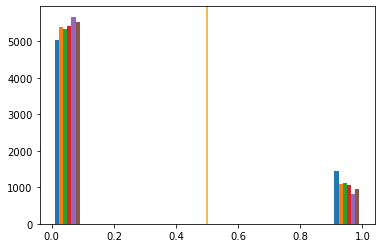

In [19]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [20]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


94.88882025941939

In [21]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [22]:
"{:0.2f}".format(pct_auc)

'96.87'

In [23]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [24]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [25]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [26]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_dense_2,n_dense_1,n_conv_3,n_conv_2,n_conv_1,maxpooling_pool_size,k_conv_3,k_conv_2,k_conv_1,dropout_2,dropout_1,avepooling_pool_size,activation,mean,std
6,512,768,768,512,512,2,7,7,3,0.25,0.22,2,relu,0.935791,0.003756
17,512,768,512,768,512,4,7,7,7,0.25,0.22,2,relu,0.933646,0.002797
14,512,768,768,512,512,4,3,7,7,0.25,0.30,2,relu,0.933045,0.002490
2,512,768,768,512,768,4,3,7,7,0.25,0.22,2,relu,0.932479,0.003557
12,512,512,512,512,512,2,3,3,7,0.25,0.30,2,elu,0.911716,0.006474
11,512,768,512,768,768,4,7,3,7,0.25,0.22,2,elu,0.909503,0.002990
4,512,512,512,512,768,2,7,3,7,0.25,0.22,4,elu,0.903497,0.002703
7,512,768,768,512,512,2,7,7,7,0.25,0.30,2,elu,0.901198,0.015270
0,512,768,768,512,512,2,7,3,7,0.25,0.30,2,elu,0.899602,0.007049
1,512,512,768,768,768,4,7,7,3,0.25,0.22,2,elu,0.898778,0.003801


## Creating best model from the best param and train it for 60 epochs

In [27]:
list(best_param.items())

[('n_dense_2', 512),
 ('n_dense_1', 768),
 ('n_conv_3', 768),
 ('n_conv_2', 512),
 ('n_conv_1', 512),
 ('maxpooling_pool_size', 2),
 ('k_conv_3', 7),
 ('k_conv_2', 7),
 ('k_conv_1', 3),
 ('dropout_2', 0.25),
 ('dropout_1', 0.22),
 ('avepooling_pool_size', 2),
 ('activation', 'relu')]

In [30]:
n_dense_2= 512
n_dense_1= 768
n_conv_3= 768
n_conv_2= 512
n_conv_1= 512
maxpooling_pool_size= 2
k_conv_3= 7
k_conv_2= 7
k_conv_1= 3
dropout_2= 0.25
dropout_1= 0.22
avepooling_pool_size= 2
activation= 'relu'
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=activation))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])


Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_189 (Conv1D)          (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 44, 512)           0         
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 38, 512)           1835520   
_________________________________________________________________
average_pooling1d_63 (Averag (None, 19, 512)           0         
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 13, 768)           2753280   
_________________________________________________________________
global_average_pooling1d_51  (None, 768)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 768)             

In [31]:
output_dir= 'model_ouput/tune-sklearn-1'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [32]:
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/60
456/456 [==============================] - 25s 55ms/step - loss: 0.8921 - accuracy: 0.6301 - val_loss: 0.8564 - val_accuracy: 0.6901
Epoch 2/60
456/456 [==============================] - 25s 56ms/step - loss: 0.4614 - accuracy: 0.8204 - val_loss: 0.6183 - val_accuracy: 0.7708
Epoch 3/60
456/456 [==============================] - 25s 55ms/step - loss: 0.3622 - accuracy: 0.8610 - val_loss: 0.3411 - val_accuracy: 0.8718
Epoch 4/60
456/456 [==============================] - 25s 55ms/step - loss: 0.3108 - accuracy: 0.8795 - val_loss: 0.3053 - val_accuracy: 0.8834
Epoch 5/60
456/456 [==============================] - 25s 55ms/step - loss: 0.2881 - accuracy: 0.8901 - val_loss: 0.2890 - val_accuracy: 0.8919
Epoch 6/60
456/456 [==============================] - 25s 55ms/step - loss: 0.2614 - accuracy: 0.9016 - val_loss: 0.2637 - val_accuracy: 0.8999
Epoch 7/60
456/456 [==============================] - 25s 55ms/step - loss: 0.2407 - accuracy: 0.9100 - val_loss: 0.2702 - val_accuracy:

Epoch 56/60
456/456 [==============================] - 25s 55ms/step - loss: 0.0756 - accuracy: 0.9731 - val_loss: 0.2689 - val_accuracy: 0.9424
Epoch 57/60
456/456 [==============================] - 25s 55ms/step - loss: 0.0804 - accuracy: 0.9708 - val_loss: 0.2487 - val_accuracy: 0.9469
Epoch 58/60
456/456 [==============================] - 25s 55ms/step - loss: 0.0734 - accuracy: 0.9728 - val_loss: 0.2505 - val_accuracy: 0.9455
Epoch 59/60
456/456 [==============================] - 25s 55ms/step - loss: 0.0704 - accuracy: 0.9745 - val_loss: 0.2513 - val_accuracy: 0.9467
Epoch 60/60
456/456 [==============================] - 25s 55ms/step - loss: 0.0755 - accuracy: 0.9728 - val_loss: 0.2325 - val_accuracy: 0.9480


In [ ]:
# model.load_weights(output_dir+"/weights.49.hdf5") # 94.22 val accuracy

In [34]:
y_hat = model.predict(X_valid)

In [35]:
len(y_hat)

6476

In [36]:
y_hat[0]

array([6.9517664e-05, 1.2823284e-11, 1.5929148e-08, 5.1007139e-11,
       4.3575806e-08, 9.9993050e-01], dtype=float32)

In [37]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

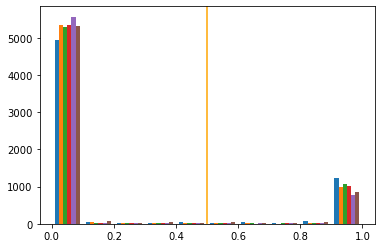

In [38]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [39]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [40]:
"{:0.2f}".format(pct_auc)

'99.60'

In [41]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [42]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [43]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.007, 0.0, 0.0, 0.0, 0.0, 0.993]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.001, 0.987, 0.0, 0.0, 0.012, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
